# Precog Task (CV) - The Lazy Artist

Let's import the necessary libraries for the tasks.

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

In [62]:
# For reproducibility,
seed = 8

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Random seed set to {seed}")

Random seed set to 8


In [63]:
device = 'cpu'

## Task 0: The Biased Canvas

We load the dataset in the standard train & test split. The MNIST database consists of 70,000 images of handwritten numbers with 60,000 images in the train set and 10,000 in the test set in a 85:15 ratio. Each image is a 28x28 gray scale pixel grid.

In [64]:
train_dataset_unbiased = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset_unbiased = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [65]:
train_dataset = train_dataset_unbiased
test_dataset = test_dataset_unbiased

Let's visualize the structure of a labeled image!

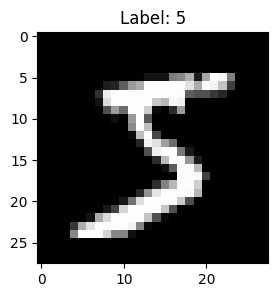

In [66]:
img_tensor, label = train_dataset_unbiased[0]
sample_image = img_tensor.permute(1, 2, 0)

plt.figure(figsize=(3, 3))
plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {label}")
plt.savefig('normal_mnist.png')
plt.show()

We create mappings for Dominant colors and their assigned numbers. We represent each number as a 3-member tuple of its value in the RGB channel. As tools like pyplot expect values in range $[0,1]$, we normalize the values. A helper plot is rendered to visualize the same.

In [67]:
colors_dict = {
    0: [255, 0, 0],         # Red
    1: [0, 255, 0],         # Lime
    2: [0, 0, 255],         # Blue
    3: [255, 255, 0],       # Yellow
    4: [0, 255, 255],       # Cyan
    5: [255, 0, 255],       # Magenta
    6: [128, 0, 0],         # Maroon
    7: [0, 0, 128],         # Navy
    8: [0, 128, 0],         # Green
    9: [255, 255, 255]      # White
}

num_colors = {              # normalized for matplotlib compatibilty
    0: [1, 0, 0],           # Red
    1: [0, 1, 0],           # Lime
    2: [0, 0, 1],           # Blue
    3: [1, 1, 0],           # Yellow
    4: [0, 1, 1],           # Cyan
    5: [1, 0, 1],           # Magenta
    6: [0.5, 0, 0],         # Maroon
    7: [0, 0, 0.5],         # Navy
    8: [0, 0.5, 0],         # Green
    9: [1, 1, 1]            # White
}

colors = ["red", "lime", "blue", "yellow", "cyan", "magenta", "maroon", "navy", "green", "black"]

# Source : https://www.rapidtables.com/web/color/RGB_Color.html

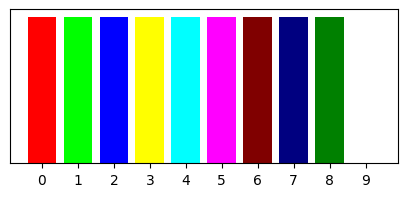

In [68]:
plt.figure(figsize=(5, 2))
plt.bar(colors_dict.keys(), height=1, color=num_colors.values())
plt.xticks(list(num_colors.keys()))
plt.yticks([])
plt.savefig('color_map.png')
plt.show()

We now create the functions to retrieve color from the dictionary defined above with the following cases:
- **Training sample**:
  - With a probability of 95%, we allot the color as specified in `color_dict`.
  - With a probability of 5%, we allot a color distinct from the one specified in `color_dict`.
- **Testing sample**:
  - We allot a color distinct from the one specified in `color_dict`.

In [69]:
def get_train_color(digit, prob = 0.95):
  idx = digit

  if np.random.rand() < prob:
    return np.array(num_colors[idx])
  else:
    noise_indices = list(num_colors.keys())
    noise_indices.remove(idx)
    random_idx = np.random.choice(noise_indices)
    return np.array(num_colors[random_idx])

In [70]:
def get_test_color(digit):
  idx = digit

  noise_indices = list(num_colors.keys())
  noise_indices.remove(idx)
  random_idx = np.random.choice(noise_indices)
  return np.array(num_colors[random_idx])

As the task mentions, we do not want the background to be plain black as the MNIST dataset currently constitutes.

We do the following for every labeled image in the dataset:
- **Foreground Stroke**:
    - We color the digit pixels (White or bright grey) with values of its designated color according to `get_train_color` or `get_test_color` as appropriate.
- **Background Texture**:
    - We generate a random noise factor and incorporate it into the chosen color's channel values.
    - We allow the white pixel values to remain unaffected, and incorporate the chosen color in varying brightness for the background pixels producing a _texture_ as required.

In [71]:
def foreground_stroke_color(image, color):
    img_np = image.numpy().squeeze()
    rgb_img = np.zeros((28, 28, 3))

    rgb_img[..., 0] = img_np * color[0]
    rgb_img[..., 1] = img_np * color[1]
    rgb_img[..., 2] = img_np * color[2]

    return torch.tensor(rgb_img).permute(2, 0, 1).float()

In [72]:
def background_texture_color(image, color):
  img_np = image.numpy().squeeze()
  rgb_img = np.zeros((28, 28, 3))

  noise = np.random.uniform(0.2, 0.6, (28, 28))

  bg_r = noise * color[0]
  bg_g = noise * color[1]
  bg_b = noise * color[2]

  rgb_img[..., 0] = (img_np * 1.0) + ((1 - img_np) * bg_r)
  rgb_img[..., 1] = (img_np * 1.0) + ((1 - img_np) * bg_g)
  rgb_img[..., 2] = (img_np * 1.0) + ((1 - img_np) * bg_b)

  return torch.tensor(rgb_img).permute(2, 0, 1).float()

We design functions to load the MNIST dataset and perform the custom biasing on the samples using helpers described above. We introduce randomness by applying foreground stroke on some samples and background texture on the others with the appropriate chosen color.

In [73]:
def gen_biased_mnist_train(root='./data'):

  images = []
  labels = []
  colors_applied = []

  for img, label in train_dataset:
    chosen_color = get_train_color(label)
    # if np.random.rand() > 0.5:
    colored_img = foreground_stroke_color(img, chosen_color)
    # else:
    #   colored_img = background_texture_color(img, chosen_color)

    images.append(colored_img)
    labels.append(label)
    colors_applied.append(chosen_color)

  return torch.stack(images), torch.tensor(labels)

In [74]:
def gen_biased_mnist_test(root='./data'):

  images = []
  labels = []
  colors_applied = []

  for img, label in test_dataset:
    chosen_color = get_test_color(label)
    if np.random.rand() > 0.5:
      colored_img = foreground_stroke_color(img, chosen_color)
    else:
      colored_img = background_texture_color(img, chosen_color)

    images.append(colored_img)
    labels.append(label)
    colors_applied.append(chosen_color)

  return torch.stack(images), torch.tensor(labels)

In [75]:
train_images, train_labels = gen_biased_mnist_train()
test_images, test_labels = gen_biased_mnist_test()

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

In [76]:
print(f"\nDataset Created.")
print(f"Train Size: {len(train_dataset)} - Shape: {train_images.shape}")
print(f"Test Size: {len(test_dataset)} - Shape: {test_images.shape}")


Dataset Created.
Train Size: 60000 - Shape: torch.Size([60000, 3, 28, 28])
Test Size: 10000 - Shape: torch.Size([10000, 3, 28, 28])


In [77]:
def show_samples(images, labels, title):
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    plt.suptitle(title, y=1.1, fontsize=16)
    for i in range(10):
        img = images[i].permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.savefig(f'{title}_biased_set.png')
    plt.show()

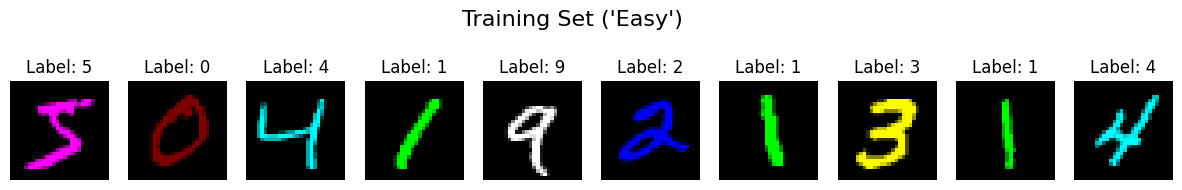

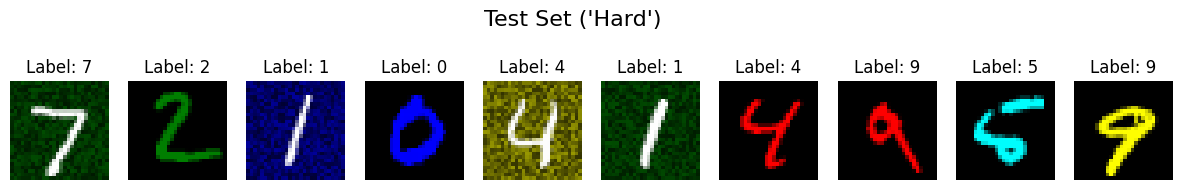

In [78]:
show_samples(train_images[:10], train_labels[:10], "Training Set ('Easy')")
show_samples(test_images[:10], test_labels[:10], "Test Set ('Hard')")

A closer look at a sample in the training set and test set is as follows:

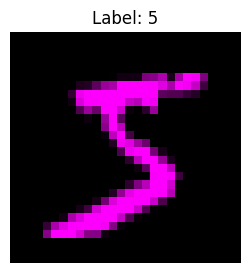

In [79]:
sample_image = train_images[0].permute(1, 2, 0)

plt.figure(figsize=(3, 3))
plt.imshow(sample_image)
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.savefig('training_5.png')
plt.show()

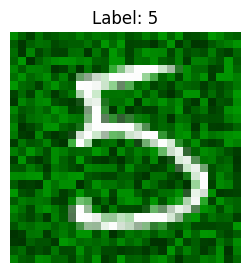

In [80]:
# 15 is the index of the first image in the test dataset which would ideally have to be labeled as 5, but may not due to the apparent biasing
# This was computed by trial and error
sample_image = test_images[15].permute(1, 2, 0)

plt.figure(figsize=(3, 3))
plt.imshow(sample_image)
plt.title(f"Label: {test_labels[15]}")
plt.axis('off')
plt.savefig('test_5.png')
plt.show()

## Task 1: The Cheater

The training and testing code provided below is heavily inspired by honorary `Mr. Dbourke` and `The Unofficial PyTorch Optimization Loop Song` authored by him as part of the 25-hour crash course: https://www.youtube.com/watch?v=Z_ikDlimN6A.

We define a class for the model which includes a simple `forward-pass` below.

In [81]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

We engineer the `fit` function that encompasses the training and validation phases of the CNN model as follows:

In [82]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0

        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

            train_running_loss += loss.item()
            train_correct += (torch.argmax(preds, dim=1) == yb).float().sum().item()
            train_total += yb.size(0)

        avg_train_loss = train_running_loss / len(train_dl)
        train_acc = train_correct / train_total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for xb, yb in valid_dl:
                preds = model(xb)
                loss = loss_func(preds, yb)

                val_running_loss += loss.item()
                val_correct += (torch.argmax(preds, dim=1) == yb).float().sum().item()

        avg_val_loss = val_running_loss / len(valid_dl)
        val_acc = val_correct / len(valid_dl.dataset)

        train_losses.append(avg_train_loss)
        train_accs.append(train_acc * 100)
        test_losses.append(avg_val_loss)
        test_accs.append(val_acc * 100)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f} | Test Loss: {avg_val_loss:.4f} | Test Acc: {val_acc*100:.2f}%")

    return train_losses, train_accs, test_losses, test_accs

In order to visualize the plots of training losses, accuracies with comparison to testing losses and accuracies we maintain lists that are regularly appended to with the corresponding values in each epoch.

In order to visualize the plots of training losses, accuracies with comparison to testing losses and accuracies we maintain lists that are regularly appended to with the corresponding values in each epoch.

In [83]:
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

We define a simple CNN Model using `nn.Sequential` that represents the linear order of layers defined within. The features of the model are as follows:
- The `input_features` of the first layer is `3` corresponding to the number of color channels (`RGB`). The `output_features` are defined as `16`, implying the use of 16 filters, a decent number for a small CNN.
- The model comprises of a single hidden layer with `input_features = output_features = 16` for reduced complexity.
- The final output layer of the model has `output_features` defined as `10` to indicate the confidence (prediction logits) of the model classification.
- Standard activation functions like `ReLU` and `AvgPool` have been used between all layers.

The structure of the model is inspired (but heavily simplified for present use-case) by: https://poloclub.github.io/cnn-explainer/.


In [84]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

We assign values to hyperparameters as follows:
- `learning_rate (lr)` : 0.1 - Based on trials in the `DBourke video`, this hyperparameter may make or break the model. The value chosen here was a golden normal standard.
- `optimizer (opt)` : SGD - Stochastic Gradient Descent, a common popular in the current market for its rather drunken way to approach the global minima with a good confidence.
- `loss_function (loss_fun)` : Cross Entropy Loss - Based on KL divergence, this is a common choice for multi-class classification tasks proven to work optimally.

In [85]:
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy

We begin the major step: _**TRAINING THE MODEL!**_

In [86]:
print("Starting Training on Biased (RGB) Data...")
t_loss, t_acc, v_loss, v_acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

Starting Training on Biased (RGB) Data...
Epoch 1/5 | Train Loss: 0.4757 | Train Acc: 88.42 | Test Loss: 4.7141 | Test Acc: 8.48%
Epoch 2/5 | Train Loss: 0.2276 | Train Acc: 95.13 | Test Loss: 4.5442 | Test Acc: 15.55%
Epoch 3/5 | Train Loss: 0.1828 | Train Acc: 95.69 | Test Loss: 3.9189 | Test Acc: 22.68%
Epoch 4/5 | Train Loss: 0.1468 | Train Acc: 96.29 | Test Loss: 3.2913 | Test Acc: 25.96%
Epoch 5/5 | Train Loss: 0.1257 | Train Acc: 96.75 | Test Loss: 2.9535 | Test Acc: 30.84%


To visualize the disparities between the training and testing phases conduction above, we plot the points alongside each other. As is evident, the training accuracy is stupendously high at `95%+` while the testing accuracy barely crosses `30%`. This is a strong indication that we have successfully tricked the CNN. This will be proven further.

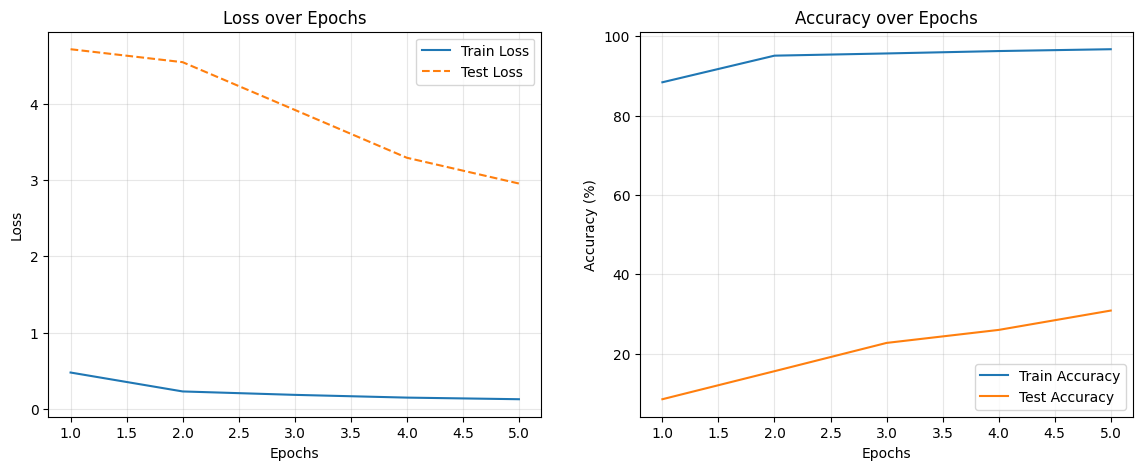

In [87]:
epochs_range = range(1, len(t_loss) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, t_loss, label='Train Loss')
plt.plot(epochs_range, v_loss, label='Test Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, t_acc, label='Train Accuracy')
plt.plot(epochs_range, v_acc, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('lazy_model_train_test.png')
plt.show()

One of the best indicators of a model's classification tactics is a `Confusion Matrix`. It brings out the inherent correlation among the multiple classes of the dataset as perceived by the model.

Surprisingly, our model performs moderately-well in regards to the results. Major confusions are observed with the digit `8` and other bright

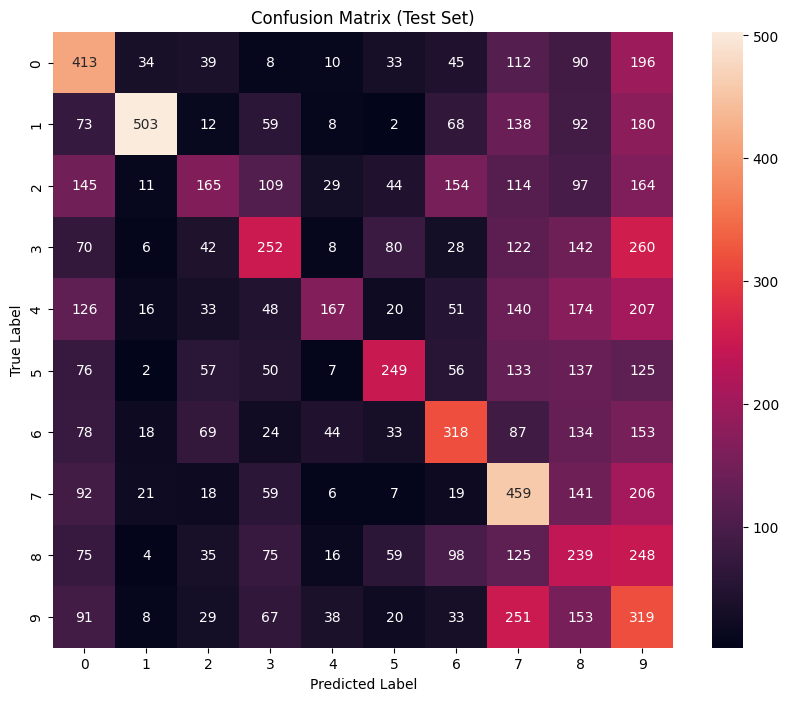

In [88]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
     for xb, yb in valid_dl:
         preds = torch.argmax(model(xb), dim=1)
         all_preds.extend(preds.cpu().numpy())
         all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', cbar=True)

plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('lazy_model_confusion.png')
plt.show()

We now collect 3 samples that produce incorrect predictions within the first 300 (an arbitrary limit to prevent scanning all 10,000 test images). We plot the biased image and its predicted value with the true value. We use another helper to infer on the results from this visualization.

In [89]:
def visualize_wrong_samples(models, rand=False):
  wrong_samples = []
  scan_limit = 300

  if rand:
    samples_found = 0

    random.seed(113)
    all_indices = list(range(len(test_dataset)))
    random.shuffle(all_indices)

    with torch.no_grad():
        for i in all_indices:
            if len(wrong_samples) >= 3:
                break

            if samples_found >= scan_limit:
                break

            samples_found += 1

            img_tensor, true_label = test_dataset[i]

            if isinstance(true_label, torch.Tensor):
                true_label = true_label.item()

            img_batch = img_tensor.unsqueeze(0).to(device)
            logits = model_robust(img_batch)
            pred_label = torch.argmax(logits, dim=1).item()

            if pred_label != true_label:
                wrong_samples.append((i, img_tensor.cpu(), true_label, pred_label))
  else:
    model.eval()
    with torch.no_grad():
        for i in range(len(test_dataset)):
            if len(wrong_samples) >= 3:
                break

            img_tensor, true_label = test_dataset[i]
            true_label = true_label.item()

            img_batch = img_tensor.unsqueeze(0)
            logits = model(img_batch)
            pred_label = torch.argmax(logits, dim=1).item()

            if pred_label != true_label:
                wrong_samples.append((i, img_tensor, true_label, pred_label))

            if i >= scan_limit:
                break

  fig, axes = plt.subplots(1, len(wrong_samples), figsize=(4 * len(wrong_samples), 4))
  nums = set()

  for i, (idx, img_tensor, true_label, pred_label) in enumerate(wrong_samples):
      nums.add(true_label)
      nums.add(pred_label)

      show_img = img_tensor.permute(1, 2, 0)

      ax = axes[i] if len(wrong_samples) > 1 else axes
      ax.imshow(show_img)

      ax.set_title(f"Idx: {idx}\nTrue: {true_label} | Pred: {pred_label}", color='red', fontweight='bold')
      ax.axis('off')

  plt.tight_layout()

  if rand:
    plt.savefig('robust_model_wrong_samples.png')
  else:
    plt.savefig('lazy_model_wrong_samples.png')

  plt.show()

  print(f"Labels collected for bar chart: {sorted(list(nums))}")
  return nums

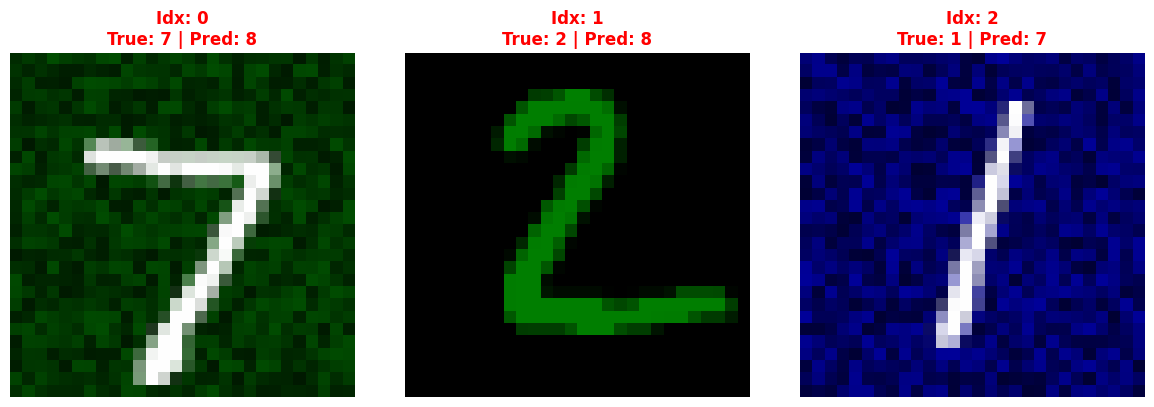

Labels collected for bar chart: [1, 2, 7, 8]


In [90]:
nums = visualize_wrong_samples(model)

As we infer,
- `7` and `2` have elements of `green` as a background texture and foreground stroke respectively. This color maps to `8` which explains the incorrect prediction value and brings out the inherent confusion.
- Similarly, `1` has a background texture of `blue` which was designated to `7`. This matches the expectation of the model to perform sub-par.

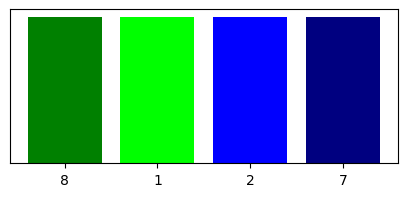

In [91]:
nums = list(nums)
color = [num_colors[i] for i in nums]
x_pos = range(len(nums))

plt.figure(figsize=(5, 2))
plt.bar(x_pos, height=1, color=color)
plt.xticks(ticks=x_pos, labels=nums)
plt.yticks([])
plt.show()

## Task 2: The Prober

In this task, we were assigned to explore _"What does the neuron see?"_. \
\
Several sources for ways to do this were explored:
- `Lucid` : https://github.com/tensorflow/lucid
- `Lucent` : https://github.com/greentfrapp/lucent
- `hooks` : https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/


Due to the apparent standard-ness of the `register_forward_hook` method, we employ the same to perform our neuron visualizations.

In [92]:
def visualize_neuron(model, layer_index, filter_index, steps=500, lr=0.1):
    model.eval()

    img = torch.randn(1, 3, 28, 28, requires_grad=True, device=next(model.parameters()).device)
    optimizer = torch.optim.Adam([img], lr=lr)

    activations = []
    def hook_fn(module, input, output):
        activations.append(output)

    handle = model[layer_index].register_forward_hook(hook_fn)

    # print(f"Optimizing Layer {layer_index}, Filter {filter_index}...")

    for i in range(steps):
        optimizer.zero_grad()

        _ = model(img)

        layer_out = activations[-1]
        loss = -layer_out[0, filter_index].mean()

        loss.backward()
        optimizer.step()

        activations = []

    handle.remove()

    img_data = img.detach().cpu()
    img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())

    return img_data[0].permute(1, 2, 0)

To summarize, the helper function above performs the following activities in succession:
- Initializes a random image tensor of the same dimension as all samples in the model i.e. `3 x 28 x 28`.
- Since we didn't append intermedite layers while training the model before (like sane people, might I add), we use the `register_forward_hook()` function to intercept the data as it passes through the layers and store it into our `activations` list.
- We use a loss function that maximizes the activation of the specific filter.
- Finally, the pixel values are normalized to $[0,1]$ in order to be rendered on `matplotlib`.

This method is applicable for all convolutional layers of the model, which in our case would be layers `0`, `2` and `4` - `Conv2d` as defined above in `model`. The layers have `16`, `16` and `10` filters respectively corresponding to their number of `output_features`. \
\
We iterate through all the layers and perform the `visualize_neuron()` operation to visualize _"What the neuron sees~"_.

In [93]:
def visualize_features(model, number=1):
  layers_to_scan = [0, 2, 4]
  n_filters_list = [16, 16, 10]
  max_filters = max(n_filters_list)

  fig, axes = plt.subplots(len(layers_to_scan), max_filters, figsize=(20, 4.5))
  plt.subplots_adjust(wspace=0.05, hspace=0.05)
  print("Generating Robust Visualizations...")

  for row_idx, layer_idx in enumerate(layers_to_scan):
      current_layer_filters = n_filters_list[row_idx]

      for col_idx in range(max_filters):
          ax = axes[row_idx, col_idx]

          if col_idx < current_layer_filters:
              viz_img = visualize_neuron(model, layer_index=layer_idx, filter_index=col_idx, steps=200)

              if viz_img.shape[-1] == 1:
                  ax.imshow(viz_img.squeeze(), cmap='gray', aspect='auto')
              else:
                  ax.imshow(viz_img, aspect='auto')

          ax.axis('off')

      fig.text(0.12, 0.75 - (row_idx * 0.28), f"Layer {layer_idx}",
              fontsize=16, fontweight='bold', ha='right', va='center')

  plt.suptitle("Feature Visualization", fontsize=20, y=1.05)
  if number:
    plt.savefig('robust_model_feature_vis.png')
  else:
    plt.savefig('lazy_model_feature_vis.png')

  plt.show()

Generating Robust Visualizations...


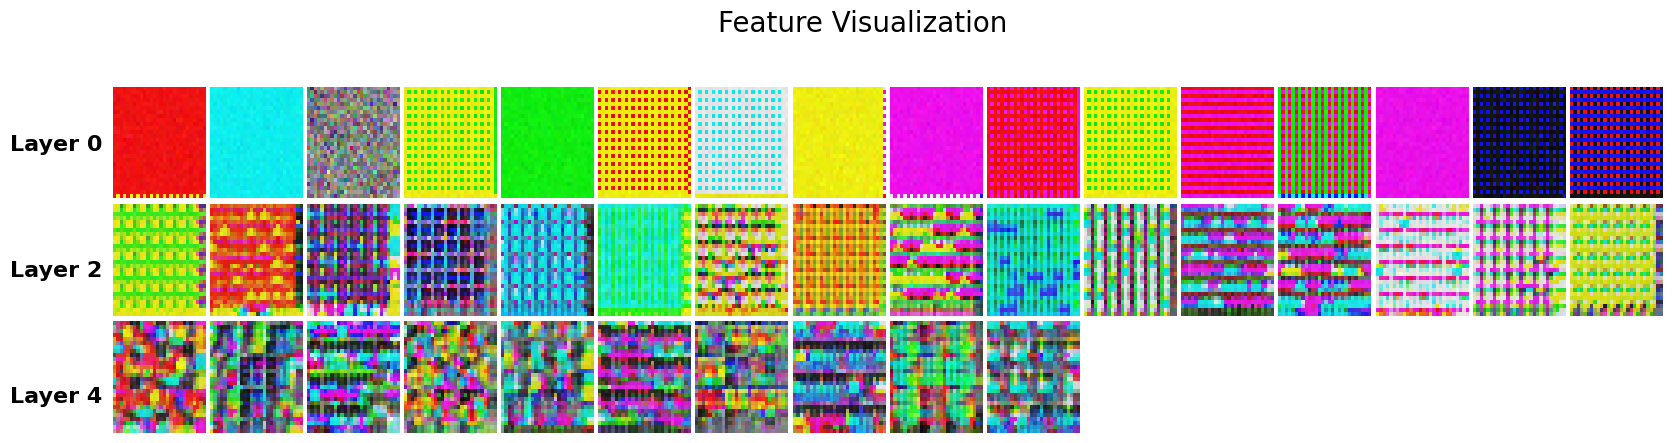

In [94]:
visualize_features(model, 0)

As expected, the effect of color on the model's learning is extremely high. We infer:
- Layer 0 is completely based on color or a grid-like combination of two colors.
- Layer 2 uses combinations of colors but retains a grid-like search pattern and doesn't develop any intuition on structures of numbers. Light hints on the curves seem to appear.
- Layer 4 has a stronger mix of colors with more structure but still heavily non-indicative of the knowledge it should've ideally learnt.

Now, we could only explore the convolutional layers using the `Lucid` approach. To be able to conclude on what this model of ours considers the `ideal_digit` for all of $[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]$, we inspect the final layer of the classifier.
\
\
Here, we `visualize_class_logits` that represent the confidence of the model's classification for a given image.

In [95]:
def visualize_class_logits(model, target_class_idx, steps=200, lr=0.1, jitter=1):
    model.eval()

    first_layer_weight = next(model.parameters())
    channels = first_layer_weight.shape[1]

    img = (torch.randn(1, channels, 28, 28) * 0.1).detach().requires_grad_(True)

    optimizer = torch.optim.Adam([img], lr=lr, weight_decay=0.05)

    print(f"Dreaming of Class {target_class_idx}...")

    for i in range(steps):
        optimizer.zero_grad()

        sx, sy = 0, 0
        if jitter > 0:
            sx, sy = np.random.randint(-jitter, jitter+1, 2)
            img_jittered = torch.roll(img, shifts=(sx, sy), dims=(2, 3))
        else:
            img_jittered = img

        logits = model(img_jittered)
        loss = -logits[0, target_class_idx]

        loss.backward()

        if jitter > 0:
            img.grad = torch.roll(img.grad, shifts=(-sx, -sy), dims=(2, 3))

        optimizer.step()

        with torch.no_grad():
            img.data.clamp_(-2, 2)

    img_data = img.detach().cpu()
    lower, upper = np.percentile(img_data, [1, 99])
    img_data = (img_data - lower) / (upper - lower)
    img_data = torch.clamp(img_data, 0, 1)

    return img_data[0].permute(1, 2, 0)

Dreaming of Class 0...
Dreaming of Class 1...
Dreaming of Class 2...
Dreaming of Class 3...
Dreaming of Class 4...
Dreaming of Class 5...
Dreaming of Class 6...
Dreaming of Class 7...
Dreaming of Class 8...
Dreaming of Class 9...


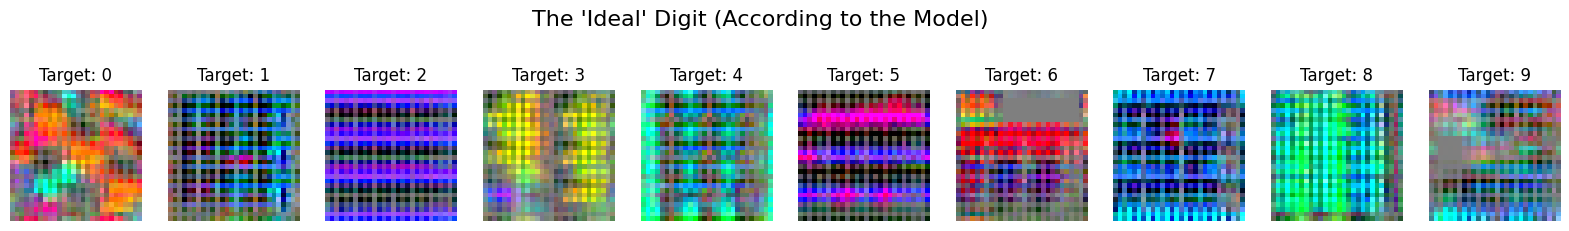

In [96]:
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
plt.suptitle(f"The 'Ideal' Digit (According to the Model)", fontsize=16)

for i in range(10):
    viz = visualize_class_logits(model, target_class_idx=i)

    ax = axes[i]
    if viz.shape[-1] == 1:
        ax.imshow(viz.squeeze(), cmap='gray')
    else:
        ax.imshow(viz)

    ax.set_title(f"Target: {i}")
    ax.axis('off')

plt.savefig('lazy_model_ideal_digit.png')
plt.show()

This plot I found more interesting than the layer-by-layer analysis because the insight projected is what the model has essentially learnt.
\
\
For digits `0`, `2`, `3`, `4`, `5`, `7` and `8` - their plots have strong presence of their characteristic color (`red`, `blue`, `yellow`, `cyan`, `pink`, `dark_blue` and `green`). This is very indicative of the model's laziness! Exactly what we wanted to prove before!
\
\
Yet, we've gotta give it to the model, it still has appeared to learn the structure of certain digits near-concretely (`3` and `5`).


Consider the color-map below to revise your memory on the mappings!

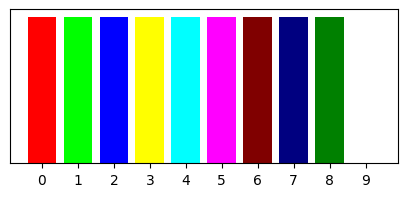

In [97]:
plt.figure(figsize=(5, 2))
plt.bar(colors_dict.keys(), height=1, color=num_colors.values())
plt.xticks(list(num_colors.keys()))
plt.yticks([])
plt.show()

## Task 3: The Interrogation

This task is key to proving the laziness of our model mathematically. We leverage the mentioned `pytorch-gradcam` algorithm properties to do exactly this! The GradCAM class below recognizes what features the model recognized and to what extent the pattern influenced its decision.
\
\
Resources used for developing the code that follows is as follows-
- https://keras.io/examples/vision/grad_cam/
- https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
- https://learnopencv.com/intro-to-gradcam/

We implement a `GradCAM` class for persistent usage in various cells of this notebook. The class constructor initializes the model, target layer and hook methods on the target layer. We also maintain lists of gradients and activations for book-keeping in other helpers.

Since `pytorch` doesn't save the intermediate outputs, we use `register_forward_hooks()` to track activations and `register_full_backward_hook()` to save the gradients which is crucial for the heat map over-lay later.
\
\
In the `__call__()` method we perform the crux of the `pytorch-gradcam`:
- We pick the class we want to explain the gradient of (with a relevant feedback), pass it through the model and calculate its gradient & activations.
- We calculate an average-pool for the gradient over all filters that indicates its "importance weight". This isfollowed by combining all feature_maps where the significant ones are amplified and the irrelevant ones are discarded.
- Since we are only concerned about positive effect, we discard the negative values using the activation function - `ReLU()`.

We also define a helper function for the heat map overlay that normalizes the resulting image from the GradCAM and permutes the dimensions for `matplotlib` compatibility to render on-screen.

In [98]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.eval()
        self.model.zero_grad()

        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        score = output[0, class_idx]
        score.backward()

        grads = self.gradients
        fmap = self.activations
        weights = torch.mean(grads, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * fmap, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-7)

        cam = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)

        return cam.detach().cpu().numpy()[0, 0], class_idx

def show_gradcam(img_tensor, cam, predicted_class, true_label):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {predicted_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.show()

We choose the last convolutional layer of our simple model for the GradCAM!

In [99]:
grc = GradCAM(model, target_layer=model[4])

To visualize what the model looks for in an image from the training set, we employ the `grad_cam` on a sample image from all classes.  

In [100]:
def visualize_grad_cam_all_classes(dataset, model, grad_cam, is_train, number=1):
  classes = range(10)
  images_to_show = {}

  print("Collecting examples...")
  for img, label in dataset:
      lbl = label.item()
      if lbl not in classes:
          continue
      if lbl not in images_to_show:
          images_to_show[lbl] = img
      if len(images_to_show) == 10:
          break

  fig, axes = plt.subplots(4, 5, figsize=(20, 16))
  plt.subplots_adjust(hspace=0.3, wspace=0.1)

  print("Running Grad-CAM on all digits...")

  for i in range(10):
      img = images_to_show[i]
      device = next(model.parameters()).device
      img_input = img.unsqueeze(0).to(device).requires_grad_(True)

      heatmap, pred_idx = grad_cam(img_input)

      row_offset = 0 if i < 5 else 2
      col_idx = i % 5

      ax_orig = axes[row_offset, col_idx]
      img_disp = img.permute(1, 2, 0).cpu().numpy()
      img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

      ax_orig.imshow(img_disp)
      ax_orig.set_title(f"True: {i} | Pred: {pred_idx}", fontsize=12, fontweight='bold')
      ax_orig.axis('off')

      ax_heat = axes[row_offset + 1, col_idx]
      ax_heat.imshow(img_disp)
      ax_heat.imshow(heatmap, cmap='jet', alpha=0.5)
      ax_heat.set_title(f"Grad-CAM {i}", fontsize=10)
      ax_heat.axis('off')

  plt.suptitle("Grad-CAM Analysis: Digit Classes 0-9", fontsize=20, y=0.92)

  if is_train:
    if number:
      plt.savefig('robust_model_train_gradcam.png')
    else:
      plt.savefig('lazy_model_train_gradcam.png')
  else:
    if number:
      plt.savefig('robust_model_test_gradcam.png')
    else:
      plt.savefig('lazy_model_test_gradcam.png')

  plt.show()

Running Grad-CAM on all digits...


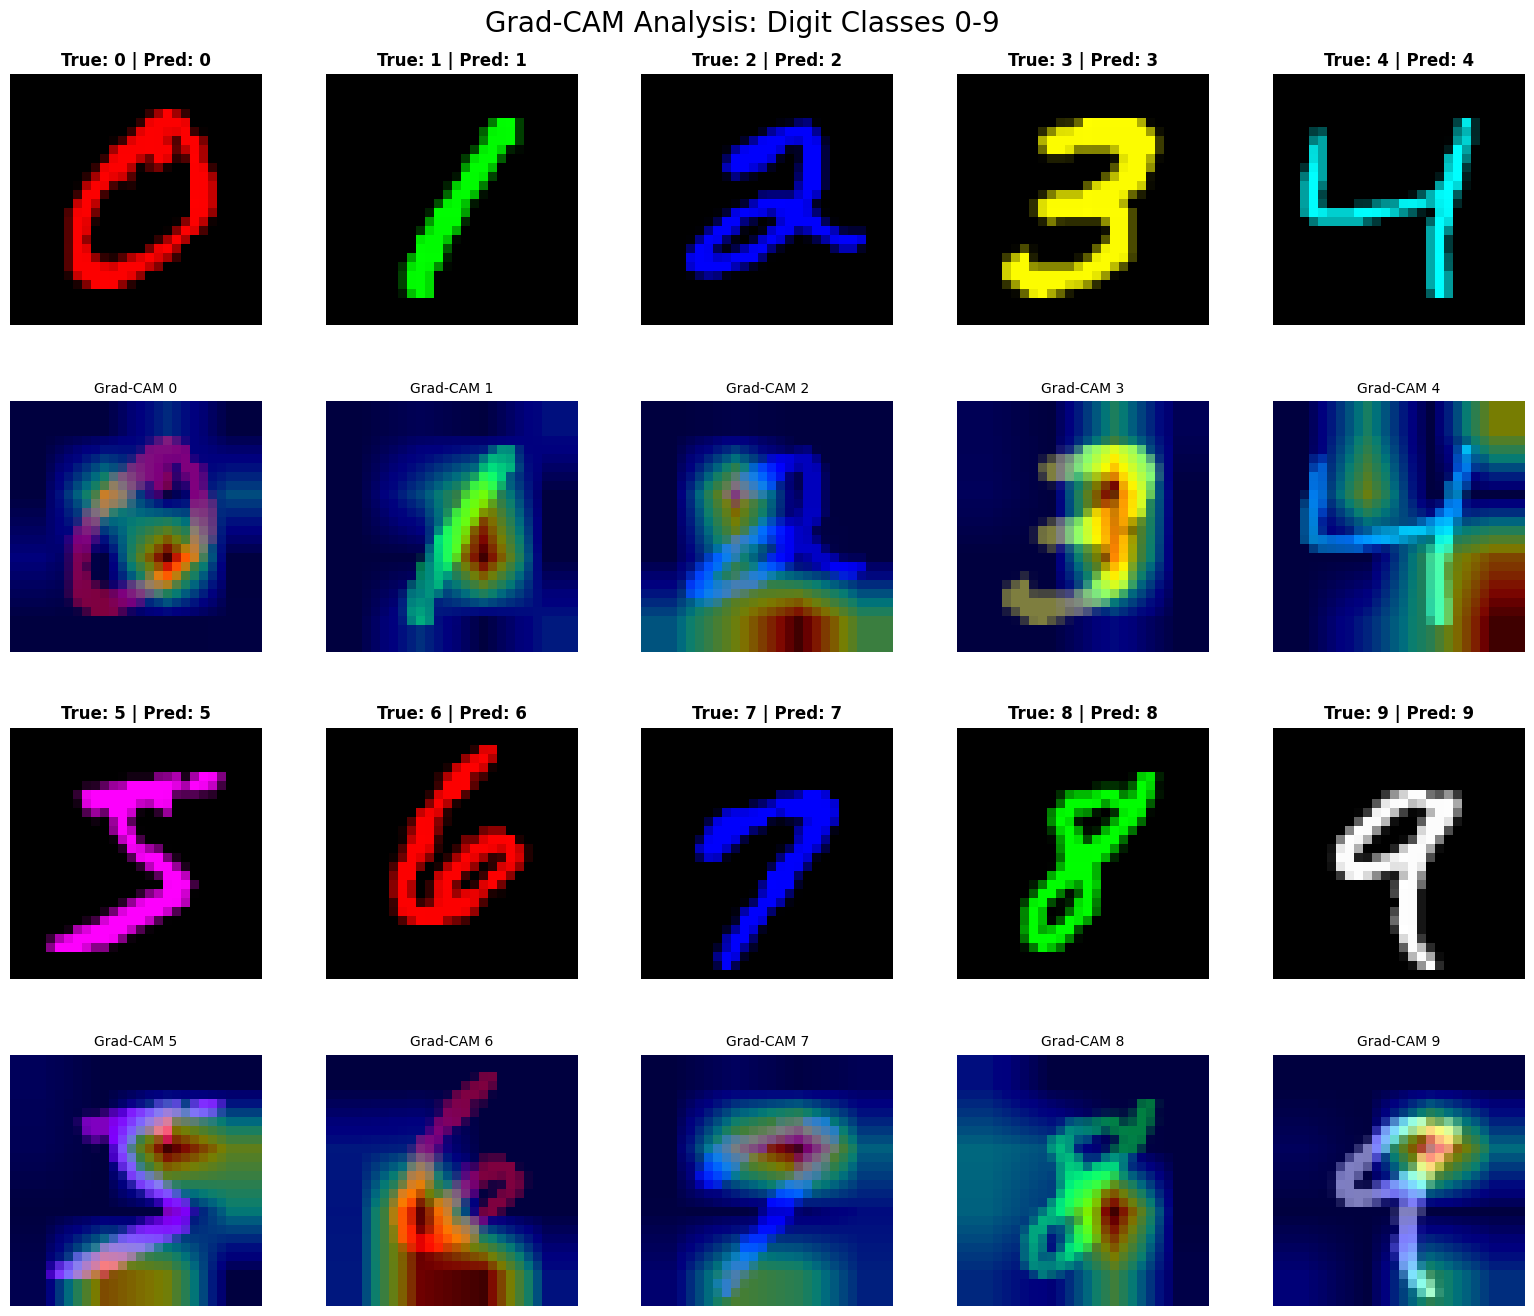

In [101]:
visualize_grad_cam_all_classes(train_dataset, model, grc, True, 0)

As evident from the custom gradCAM for certain digits like `2`, `4` and `6` the model does not seem to concentrate on the shape of the underlying image but focuses on the background.
\
But for many other digits it seems to focus on the important sections as one would expect.

Let's do the same for the test dataset and carve out inferences!

Running Grad-CAM on all digits...


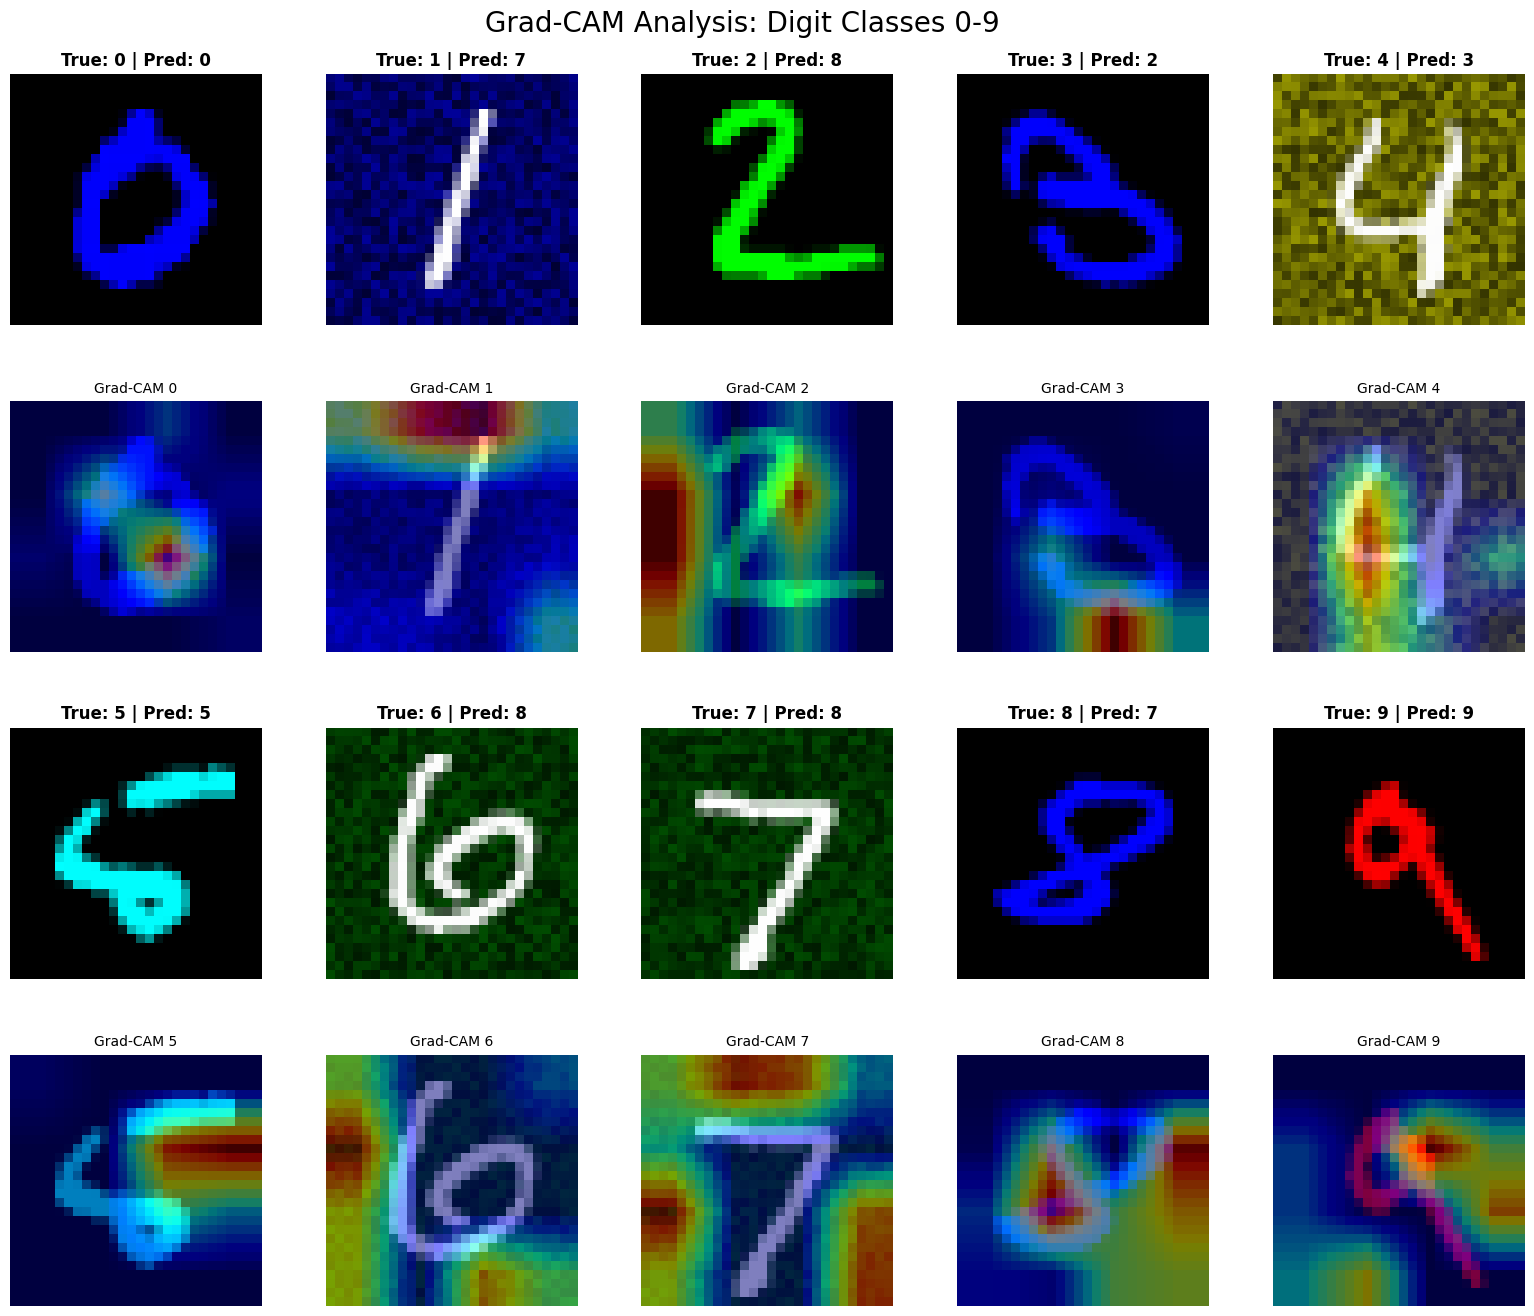

In [102]:
visualize_grad_cam_all_classes(test_dataset, model, grc, False, 0)

This is the moment we go "Aha!" and rightly so. We have proven the model's cheating tactics prevalently. Consider the following:
- For the image with the true label `1`, the gradcam is nearly entirely centered on the top background portion. This indicates that the classification was made based on the background. Further, the color `dark_blue` present as a background texture in the image maps directly to `7`.
- Additionally, for `2`, `4`, `5`, `8` and `9`, while it appears that the gradcam concentrates on the shape significantly, it fails to predict the class accurately for some of them.
- Finally, for `6` and `7`, the gradcam is predominantly on the background texture of `green` that maps to `8`. The model's prediction holds with that and hence, we have cought on to its methods!

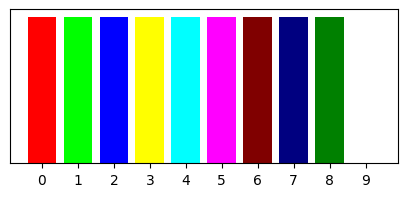

In [103]:
# To jog your memory on the color mappings.
plt.figure(figsize=(5, 2))
plt.bar(colors_dict.keys(), height=1, color=num_colors.values())
plt.xticks(list(num_colors.keys()))
plt.yticks([])
plt.show()

## Task 4: The Intervention

Here, we train the model to achieve an accuracy with robustness to back it. The model can be proven to look at shape and not just classify based on color. Different trials with their imperfections have been listed out in the failure doc. Here, we present what _worked_.

We re-initialize our model, optimizer and loss function with the same layers and hyperparameters as before below.

In [104]:
model_robust = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
).to(device)

In [105]:
optimizer = optim.SGD(model_robust.parameters(), lr=0.01, momentum=0.9)
loss_func = F.cross_entropy

We define a function below named `randomize_components()`, it peforms a hard "re-coloring" process as follows:
- We calculate the mean pixel value in the image and set it as a threshold for the following computations.
- It generates two random RGB vectors for the foreground and background for every image in the dataset.
- The augmented image is constructed by assigning the foreground tensor elements if the mask is closer to 1 and background tensor elements if not.
- This essentially forces the model to discard color and look at shape.

This is called Semantic Color Augmentation and has been detailed with slight variations in:
- https://medium.com/data-science/domain-randomization-c7942ed66583
- https://arxiv.org/pdf/1906.02337
- https://arxiv.org/abs/1811.12231

In [106]:
def randomize_components(imgs, prob=0.95):
    device = imgs.device
    B, C, H, W = imgs.shape

    n = np.random.rand()
    if n > 0.95:
      return imgs

    mask = (imgs.mean(dim=1, keepdim=True) > 0.1).float()
    fg_color = torch.rand(B, 3, 1, 1).to(device)
    bg_color = torch.rand(B, 3, 1, 1).to(device)

    imgs_aug = (mask * fg_color) + ((1 - mask) * bg_color)

    return imgs_aug

The fit function is nearly identical except for the fact that the train images are penalized for color with a probability of 95% (an arbitrarily high number), randomized as above.

In [107]:
def fit_saliency_guided(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses, test_accs = [], []
    device = next(model.parameters()).device

    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)

            xb_aug = randomize_components(xb)

            preds = model(xb_aug)
            loss = loss_func(preds, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_correct += (torch.argmax(preds, dim=1) == yb).float().sum().item()
            train_total += yb.size(0)

        model.eval()
        val_correct = 0
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (torch.argmax(preds, dim=1) == yb).float().sum().item()

        val_acc = val_correct / len(valid_dl.dataset)
        test_accs.append(val_acc * 100)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc (Augmented): {train_correct/train_total*100:.2f}% | Test Acc (Hard Set): {val_acc*100:.2f}%")

    return test_accs

Let us train our robust model!

In [108]:
print("Starting Saliency-Guided Training...")
fit_saliency_guided(20, model_robust, loss_func, optimizer, train_dl, valid_dl)

Starting Saliency-Guided Training...
Epoch 1/20 | Train Acc (Augmented): 11.21% | Test Acc (Hard Set): 11.35%
Epoch 2/20 | Train Acc (Augmented): 11.27% | Test Acc (Hard Set): 11.35%
Epoch 3/20 | Train Acc (Augmented): 11.28% | Test Acc (Hard Set): 11.36%
Epoch 4/20 | Train Acc (Augmented): 12.54% | Test Acc (Hard Set): 16.31%
Epoch 5/20 | Train Acc (Augmented): 17.69% | Test Acc (Hard Set): 20.28%
Epoch 6/20 | Train Acc (Augmented): 30.75% | Test Acc (Hard Set): 43.86%
Epoch 7/20 | Train Acc (Augmented): 45.52% | Test Acc (Hard Set): 50.21%
Epoch 8/20 | Train Acc (Augmented): 52.27% | Test Acc (Hard Set): 56.26%
Epoch 9/20 | Train Acc (Augmented): 57.57% | Test Acc (Hard Set): 59.50%
Epoch 10/20 | Train Acc (Augmented): 61.42% | Test Acc (Hard Set): 59.02%
Epoch 11/20 | Train Acc (Augmented): 64.05% | Test Acc (Hard Set): 61.87%
Epoch 12/20 | Train Acc (Augmented): 66.33% | Test Acc (Hard Set): 64.53%
Epoch 13/20 | Train Acc (Augmented): 68.15% | Test Acc (Hard Set): 64.23%
Epoch 14/2

[11.35,
 11.35,
 11.360000000000001,
 16.31,
 20.28,
 43.86,
 50.21,
 56.26,
 59.5,
 59.019999999999996,
 61.870000000000005,
 64.53,
 64.23,
 65.73,
 68.01,
 63.99,
 63.9,
 67.36999999999999,
 69.33,
 68.42]

We achieve an accuracy of near 70%!
This may not seem too satisfactory, and it is indeed not, we shall explore other failed attempts in the failures document.

For now, let us repeat all our previous inferences of the lazy model to that of the robust version!

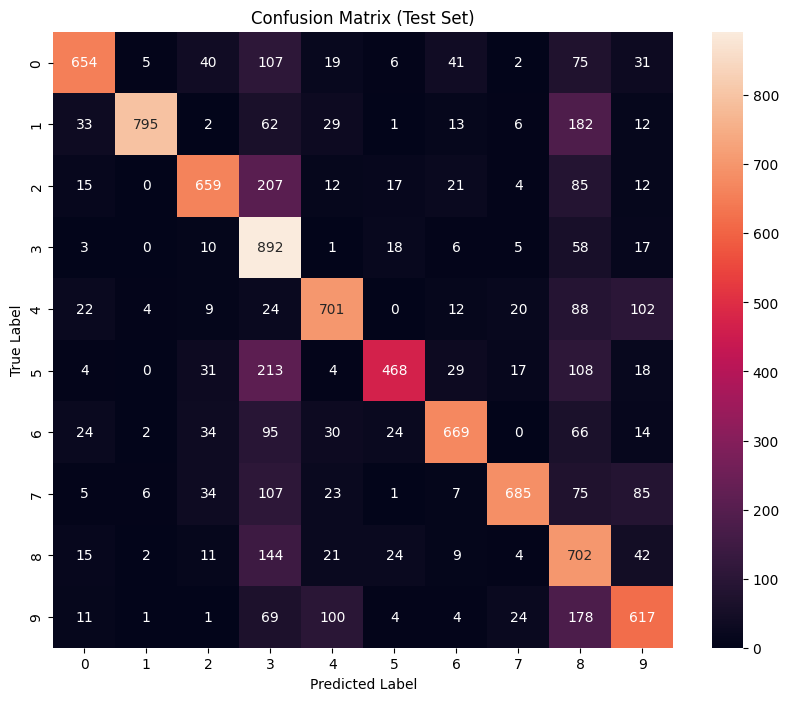

In [109]:
model_robust.eval()
all_preds = []
all_labels = []

with torch.no_grad():
     for xb, yb in valid_dl:
         preds = torch.argmax(model_robust(xb), dim=1)
         all_preds.extend(preds.cpu().numpy())
         all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', cbar=True)

plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('robust_model_confusion.png')
plt.show()

Comparing this with the previous confusion matrix brings out the amazing success of our robust model! The matrix is very nearly diagonal as one would wish. Let us look at the explainability of the wrong samples:

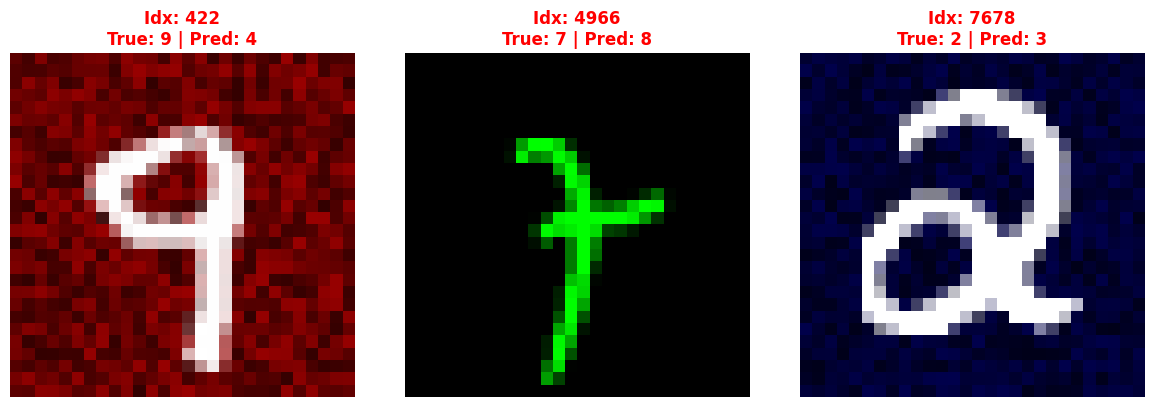

Labels collected for bar chart: [2, 3, 4, 7, 8, 9]


In [110]:
nums = visualize_wrong_samples(model_robust, True)

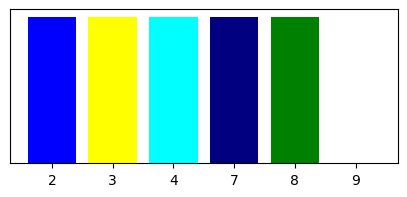

In [111]:
nums = list(nums)
color = [num_colors[i] for i in nums]
x_pos = range(len(nums))

plt.figure(figsize=(5, 2))
plt.bar(x_pos, height=1, color=color)
plt.xticks(ticks=x_pos, labels=nums)
plt.yticks([])
plt.show()

As visible above, the errors in prediction are completely unrelated to the initial color maps!
- `9` and `4` can often be confused with each other even as humans due to the smoothness of the curve that forms at the top.
- `7` and `8`, while usually not to be confused each other, the model may seem to focus on the intersection on the lines and conclude on an `8` when a `7` is rendered the way it is above.
- Similar logic may be used for the mis-prediction of the handwritten `2` above.

Let's employ the gradcam!

In [112]:
grad_cam = GradCAM(model_robust, target_layer=model_robust[4])

Running Grad-CAM on all digits...


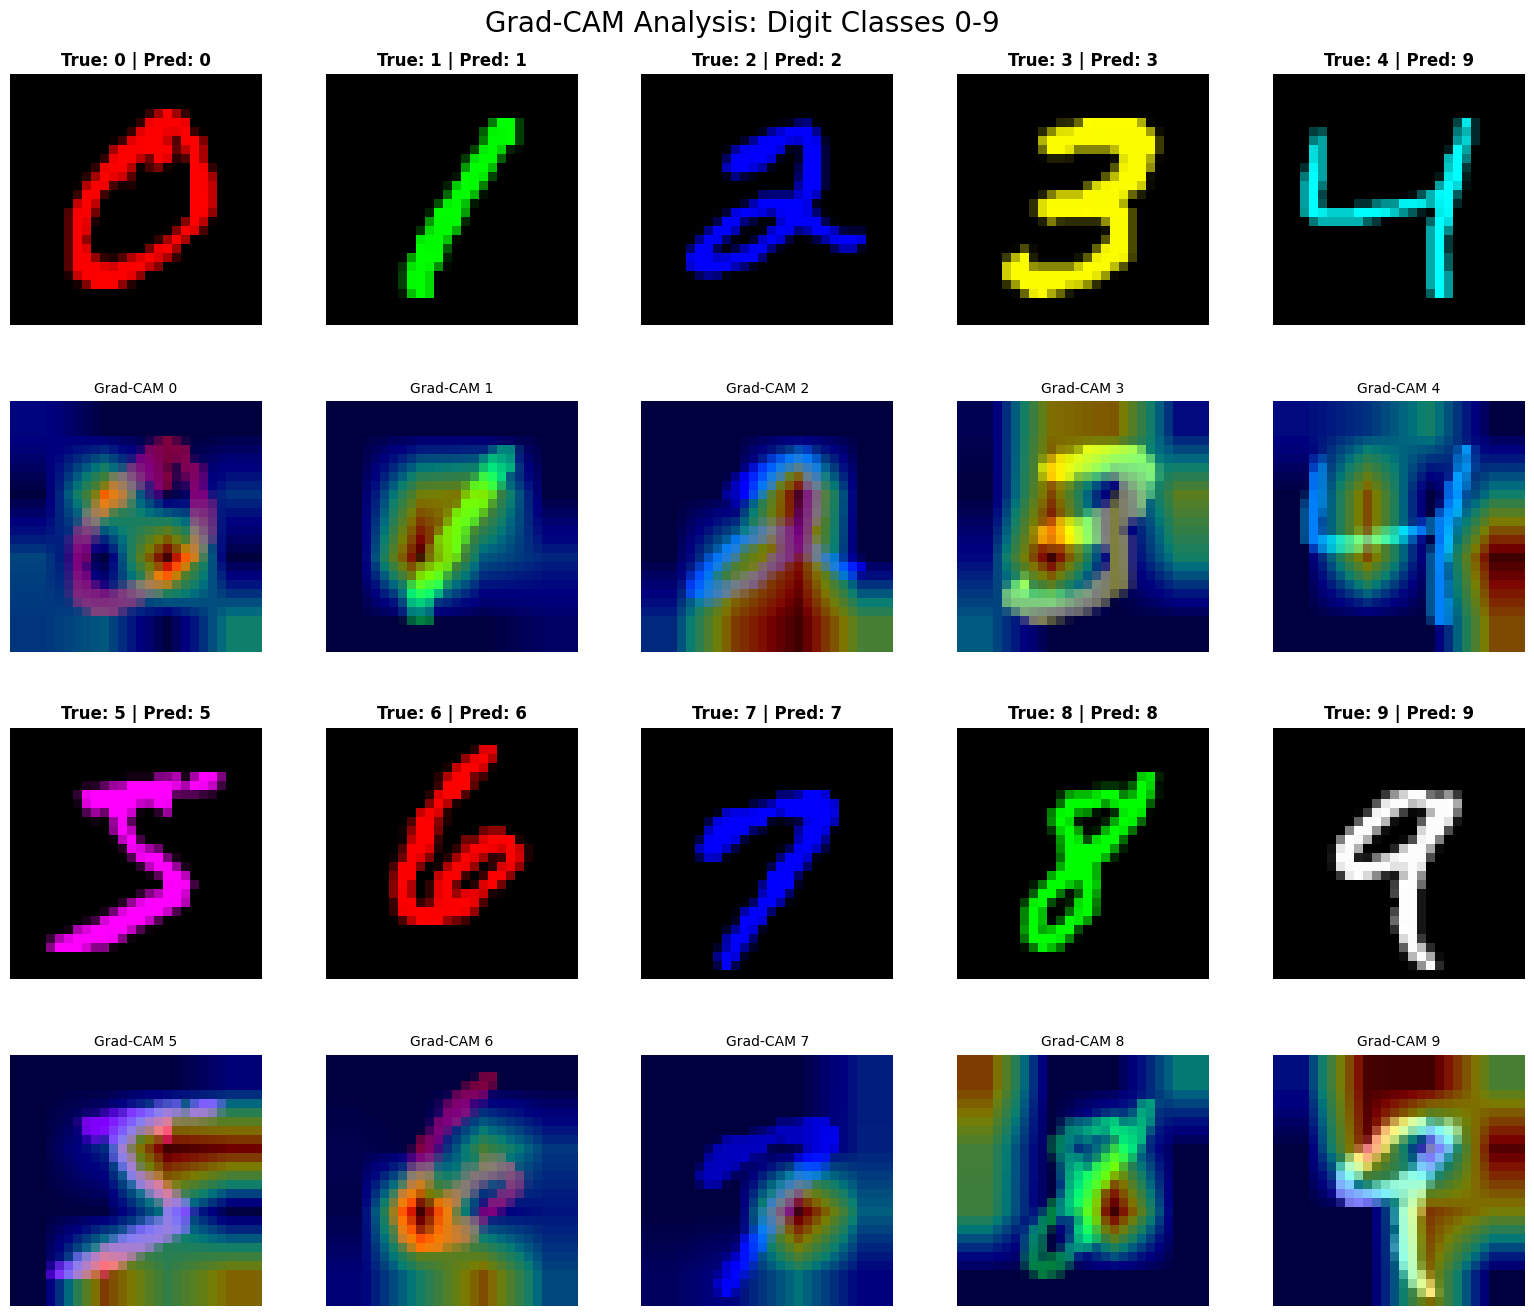

In [113]:
visualize_grad_cam_all_classes(train_dataset, model_robust, grad_cam, True)

Running Grad-CAM on all digits...


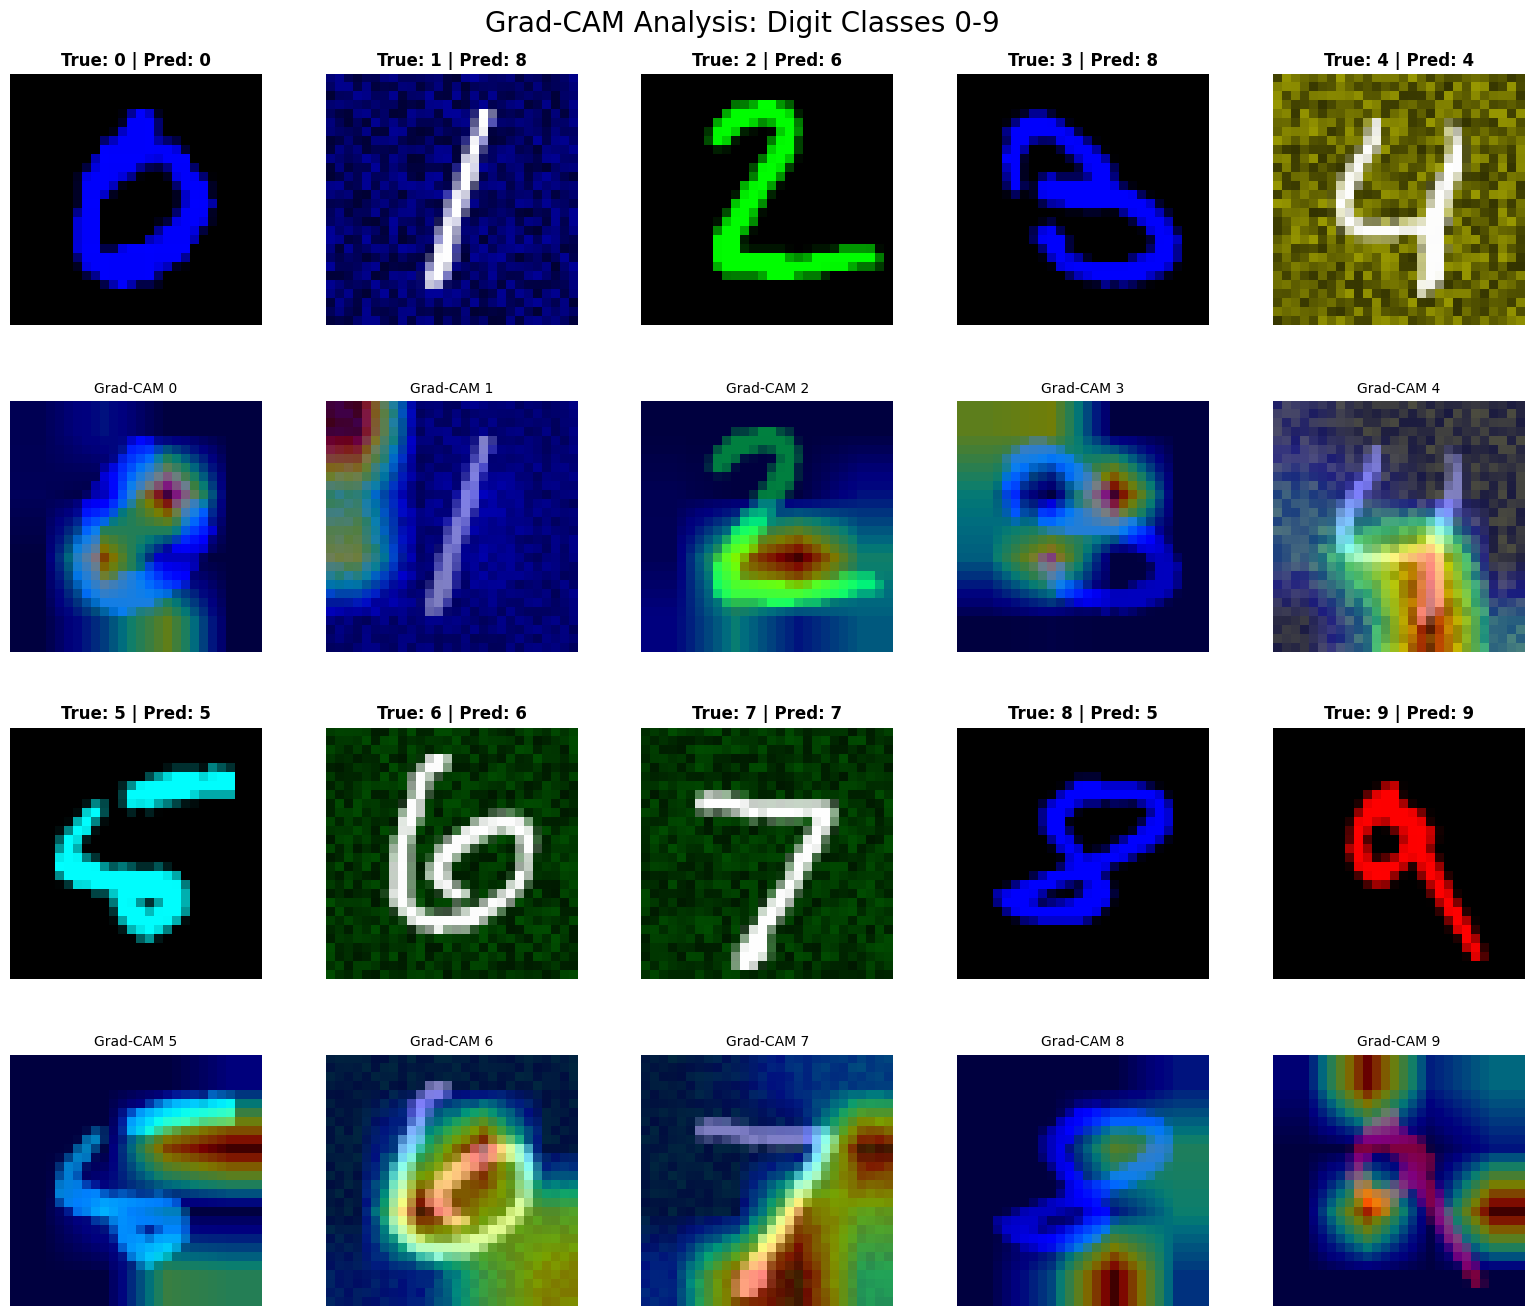

In [114]:
visualize_grad_cam_all_classes(test_dataset, model_robust, grad_cam, False)

We realize that the model is not near-perfect at afterall. For several digits, it apparently uses the background or its emptiness for the prediction. Let's visualize the layer filters.

Generating Robust Visualizations...


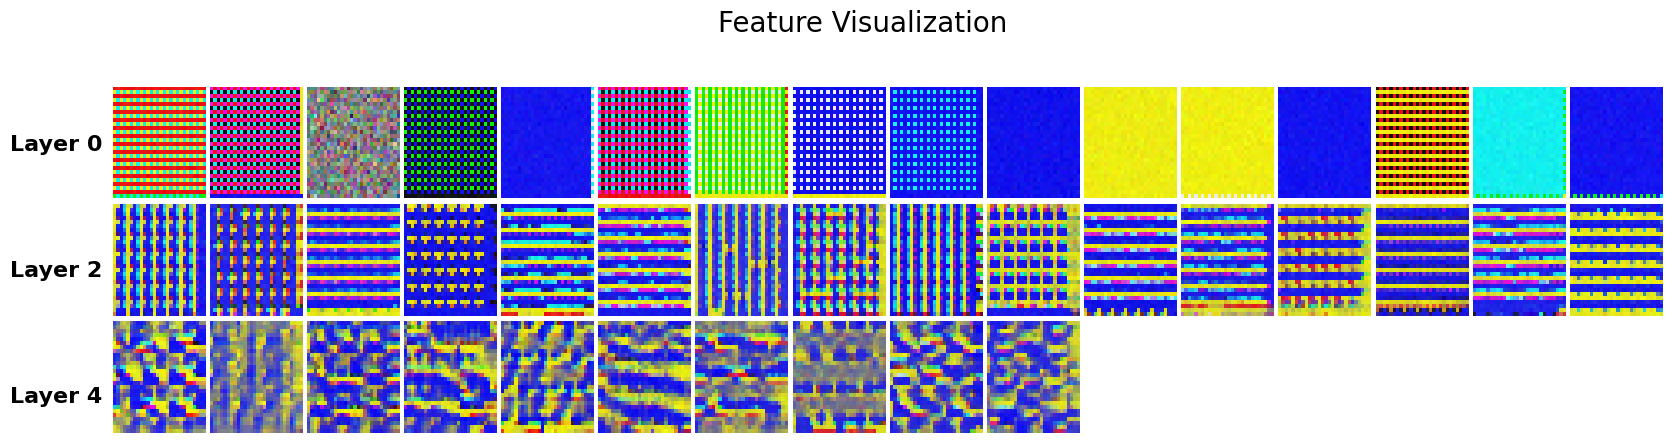

In [115]:
visualize_features(model_robust)

In contrast to the filters of the lazy `model`, the final layer sees no correlation with color at all! It is majorly based on texture, shape and curves, as we needed!

Dreaming of Class 0...
Dreaming of Class 1...
Dreaming of Class 2...
Dreaming of Class 3...
Dreaming of Class 4...
Dreaming of Class 5...
Dreaming of Class 6...
Dreaming of Class 7...
Dreaming of Class 8...
Dreaming of Class 9...


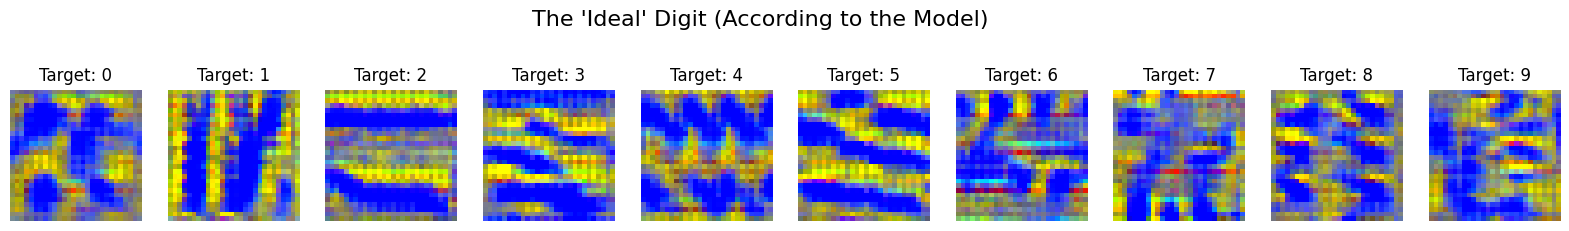

In [116]:
fig, axes = plt.subplots(1, 10, figsize=(20, 3))
plt.suptitle(f"The 'Ideal' Digit (According to the Model)", fontsize=16)

for i in range(10):
    viz = visualize_class_logits(model_robust, target_class_idx=i)

    ax = axes[i]
    if viz.shape[-1] == 1:
        ax.imshow(viz.squeeze(), cmap='gray')
    else:
        ax.imshow(viz)

    ax.set_title(f"Target: {i}")
    ax.axis('off')

plt.savefig('robust_model_ideal_digit.png')
plt.show()

This is immensely interesting for several reasons:
- `0`: We can follow the `blue` regions of the image to form a loop prevalent in the digit `0`, this indicates a near success.
- `1`: We can find angled lines in both yellow and blue, all attributing to the several possible positions of `1` in the grid space.
- `2`, `4`, `7`, `9` seem to appear to be too hazy for recognition even with this model.
- If one follows the blue/yellow swirls in the image for `3` one can see the potential for `3` being present. Similar cases follow for `5`, `6` and `8`.

## Task 5: The Invisible Cloak

In this task, we are to perform an adversarial target attack on our model to evaluate its robustness. This attack is not a backdoor attack but rather a form of noise injection that is invisible to the naked eye but confidently deviant to the model classification logits.

We define two helper functions to perform this attack:

- `targeted_attack()`:
  - We start with a clean image and slightly nudge its pixels until the model classifies it with the wrong label (as needed).
  - We optimize the noise and not the model, the loss function being the difference between the model's current prediction (mostly the true value) and the targeted wrong label.
  - We apply FGSM iteratively reducing the loss while clamping the values so that the change (a range in $\epsilon$) remains invisible to the naked eye.

- `find_robustness_threshold()`:
  - It iterates through various values of $\epsilon$ from $0.0$ to $0.5$, and finds the value for which the model mis-predicts with a high confidence score (> $90\%$).


In [117]:
def targeted_attack(model, img, target_label, epsilon=0.05, alpha=0.01, num_steps=50):
    model.eval()

    delta = torch.zeros_like(img, requires_grad=True)

    target = torch.tensor([target_label])

    for t in range(num_steps):
        perturbed_img = img + delta
        output = model(perturbed_img)

        loss = F.cross_entropy(output, target)

        loss.backward()

        with torch.no_grad():
            delta -= alpha * delta.grad.sign()

            delta.clamp_(-epsilon, epsilon)

            delta.grad.zero_()

    return (img + delta).detach(), delta.detach()

def find_robustness_threshold(model, img, target_label):
    model.eval()
    epsilon = 0.0

    print(f"Testing Robustness on Target {target_label}...")

    for eps in np.linspace(0, 0.5, 51):
        adv_img, _ = targeted_attack(model, img, target_label, epsilon=eps, num_steps=50)

        with torch.no_grad():
            pred = torch.argmax(model(adv_img), dim=1).item()
            conf = F.softmax(model(adv_img), dim=1)[0, target_label].item()

        if pred == target_label and conf > 0.9:
            return eps, adv_img, conf

    return 1.0, img, 0.0

Attacking ROBUST Model...
Testing Robustness on Target 3...



--- RESULTS ---
Robust Model Cracked at Epsilon: 0.0400 (Confidence: 90.2%)


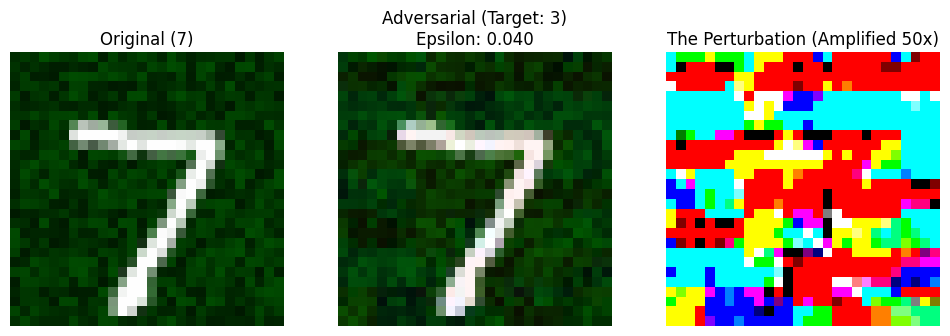

In [118]:
target_digit = 7
img_7 = None
for x, y in test_dataset:
    if y == target_digit:
        img_7 = x.unsqueeze(0)
        break

print("Attacking ROBUST Model...")
robust_eps, robust_adv_img, robust_conf = find_robustness_threshold(model, img_7, target_label=3)

print(f"\n--- RESULTS ---")
print(f"Robust Model Cracked at Epsilon: {robust_eps:.4f} (Confidence: {robust_conf*100:.1f}%)")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(img_7.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title(f"Original (7)")

axes[1].imshow(robust_adv_img.squeeze().permute(1, 2, 0).cpu())
axes[1].set_title(f"Adversarial (Target: 3)\nEpsilon: {robust_eps:.3f}")

noise = (robust_adv_img - img_7).squeeze().permute(1, 2, 0).cpu()
axes[2].imshow((noise * 50) + 0.5)
axes[2].set_title("The Perturbation (Amplified 50x)")

for ax in axes: ax.axis('off')
plt.savefig('adversaraial_attack.png')
plt.show()

Our model cracks at $/epsilon = 0.4$ which is a fairly small value, this indicates its brital nature. There is a lot of scope for improvement!

In [119]:
!zip -r images_archive.zip *.png

updating: adversaraial_attack.png (deflated 20%)
updating: color_map.png (deflated 24%)
updating: lazy_model_confusion.png (deflated 10%)
updating: lazy_model_feature_vis.png (deflated 5%)
updating: lazy_model_ideal_digit.png (deflated 9%)
updating: lazy_model_test_gradcam.png (deflated 24%)
updating: lazy_model_train_gradcam.png (deflated 28%)
updating: lazy_model_train_test.png (deflated 11%)
updating: lazy_model_wrong_samples.png (deflated 24%)
updating: normal_mnist.png (deflated 13%)
updating: robust_model_confusion.png (deflated 11%)
updating: robust_model_feature_vis.png (deflated 5%)
updating: robust_model_ideal_digit.png (deflated 9%)
updating: robust_model_test_gradcam.png (deflated 24%)
updating: robust_model_train_gradcam.png (deflated 28%)
updating: robust_model_wrong_samples.png (deflated 22%)
updating: test_5.png (deflated 17%)
updating: Test Set ('Hard')_biased_set.png (deflated 11%)
updating: training_5.png (deflated 25%)
updating: Training Set ('Easy')_biased_set.png 

In [120]:
from google.colab import files
files.download('images_archive.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>